In [1]:
# kaggle profile https://www.kaggle.com/dimka11
# Dmitry_Sokolov

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix


from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from catboost import CatBoost


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


In [2]:
data = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
print(data.shape)
data.head()

(5282, 20)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


## Первая часть. Исследование. Загрузка данных

In [3]:
# случайные строки
data.loc[np.r_[0:5, 10:15, 20:25], :]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
10,16,78.75,1218.25,Male,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0
11,70,113.05,7869.05,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0
12,69,99.50,6841.45,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),0
13,26,38.85,1025.15,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Credit card (automatic),0
14,38,102.60,4009.2,Male,1,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,0


In [4]:
data.info() # nan в дата сете нет. # np.where(pd.isnull(data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [5]:
np.where(data.applymap(lambda x: x == ' ')) # Но, есть пустыe

(array([1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [6]:
data.iloc[1048]

ClientPeriod                                  0
MonthlySpending                           25.75
TotalSpent                                     
Sex                                        Male
IsSeniorCitizen                               0
HasPartner                                  Yes
HasChild                                    Yes
HasPhoneService                             Yes
HasMultiplePhoneNumbers                     Yes
HasInternetService                           No
HasOnlineSecurityService    No internet service
HasOnlineBackup             No internet service
HasDeviceProtection         No internet service
HasTechSupportAccess        No internet service
HasOnlineTV                 No internet service
HasMovieSubscription        No internet service
HasContractPhone                       Two year
IsBillingPaperless                           No
PaymentMethod                      Mailed check
Churn                                         0
Name: 1048, dtype: object

In [7]:
# Удаление пустых
data1 = data.replace(' ', np.nan)
data1 = data1.dropna()
print(data1.shape)

data2 = pd.to_numeric(data1['TotalSpent'])
data1['TotalSpent'] = data2

# заменяем на среднее значение:

mean_ = data1['TotalSpent'].mean()
data = data.replace(' ', mean_)
data.shape

(5273, 20)


(5282, 20)

In [8]:
data = data.astype({"TotalSpent": float})

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2291.390461,0.159409,0.262022
std,24.550326,30.176464,2267.079956,0.366092,0.439776
min,0.000000,18.250000,18.800000,0.000000,0.000000
25%,9.000000,35.462500,401.587500,0.000000,0.000000
50%,29.000000,70.400000,1413.650000,0.000000,0.000000
75%,55.000000,90.050000,3795.212500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


In [11]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Анализ данных

array([[<AxesSubplot:title={'center':'ClientPeriod'}>,
        <AxesSubplot:title={'center':'MonthlySpending'}>],
       [<AxesSubplot:title={'center':'TotalSpent'}>, <AxesSubplot:>]],
      dtype=object)

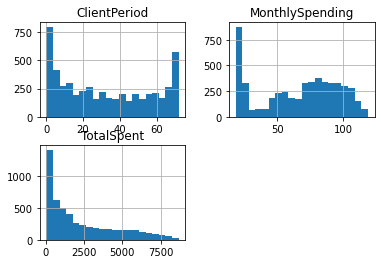

In [12]:
# Гистограммы
data[['ClientPeriod', 'MonthlySpending', 'TotalSpent']].hist(bins=20)

In [13]:
[print(data[i].value_counts(), '\n') for i in cat_cols]
print('')

Male      2655
Female    2627
Name: Sex, dtype: int64 

0    4440
1     842
Name: IsSeniorCitizen, dtype: int64 

No     2705
Yes    2577
Name: HasPartner, dtype: int64 

No     3676
Yes    1606
Name: HasChild, dtype: int64 

Yes    4761
No      521
Name: HasPhoneService, dtype: int64 

No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64 

Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64 

No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64 

No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64 

No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64 

No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess,

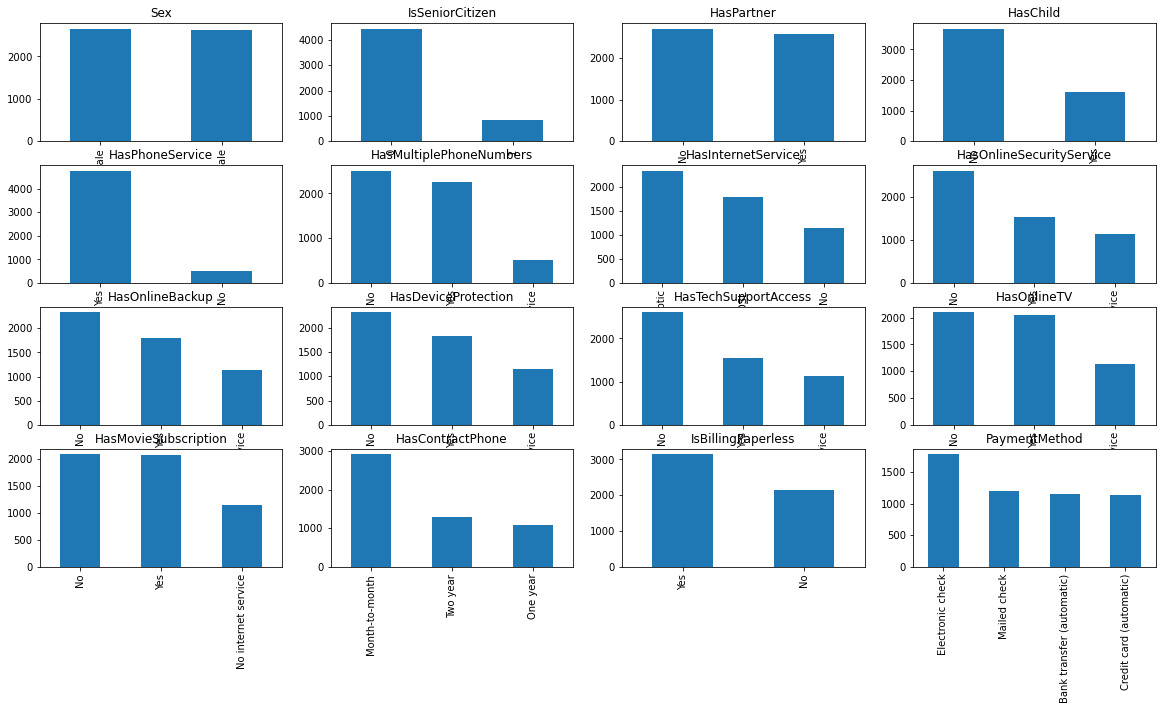

In [14]:
#data[cat_cols].value_counts().plot.bar()
# [data[i].value_counts().plot.bar() for i in cat_cols]

fig, axes = plt.subplots(figsize=(20, 10), nrows=4, ncols=4)

data['Sex'].value_counts().plot.bar(ax=axes[0,0]).title.set_text('Sex')
data['IsSeniorCitizen'].value_counts().plot.bar(ax=axes[0,1]).title.set_text('IsSeniorCitizen')
data['HasPartner'].value_counts().plot.bar(ax=axes[0,2]).title.set_text('HasPartner')
data['HasChild'].value_counts().plot.bar(ax=axes[0,3]).title.set_text('HasChild')
data['HasPhoneService'].value_counts().plot.bar(ax=axes[1,0]).title.set_text('HasPhoneService')
data['HasMultiplePhoneNumbers'].value_counts().plot.bar(ax=axes[1,1]).title.set_text('HasMultiplePhoneNumbers')
data['HasInternetService'].value_counts().plot.bar(ax=axes[1,2]).title.set_text('HasInternetService')
data['HasOnlineSecurityService'].value_counts().plot.bar(ax=axes[1,3]).title.set_text('HasOnlineSecurityService')
data['HasOnlineBackup'].value_counts().plot.bar(ax=axes[2,0]).title.set_text('HasOnlineBackup')
data['HasDeviceProtection'].value_counts().plot.bar(ax=axes[2,1]).title.set_text('HasDeviceProtection')
data['HasTechSupportAccess'].value_counts().plot.bar(ax=axes[2,2]).title.set_text('HasTechSupportAccess')
data['HasOnlineTV'].value_counts().plot.bar(ax=axes[2,3]).title.set_text('HasOnlineTV')
data['HasMovieSubscription'].value_counts().plot.bar(ax=axes[3,0]).title.set_text('HasMovieSubscription')
data['HasContractPhone'].value_counts().plot.bar(ax=axes[3,1]).title.set_text('HasContractPhone')
data['IsBillingPaperless'].value_counts().plot.bar(ax=axes[3,2]).title.set_text('IsBillingPaperless')
data['PaymentMethod'].value_counts().plot.bar(ax=axes[3,3]).title.set_text('PaymentMethod')

<AxesSubplot:>

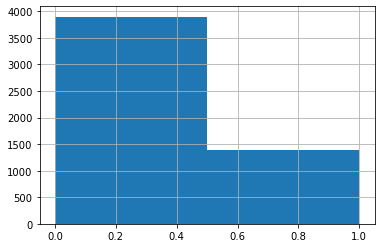

In [15]:
# Посмотрите на распределение целевой переменной
data['Churn'].hist(bins=2) # Классы достаточно сбалансированы

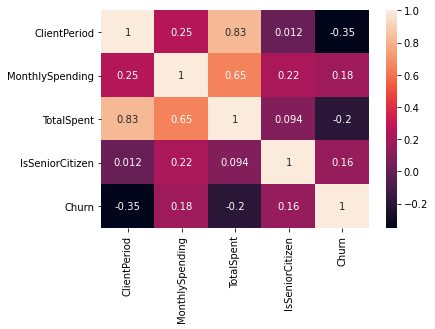

In [16]:
# корр матрица для числовых признаков
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [17]:
# pd.crosstab(data['Churn'], data['Sex'], margins=True)
pd.crosstab(data['Churn'], data['HasInternetService'], margins=True)
pd.crosstab(data['Churn'], data['HasContractPhone'], margins=True)

HasContractPhone,Month-to-month,One year,Two year,All
Churn,,,,
0,1689,962,1247,3898
1,1231,120,33,1384
All,2920,1082,1280,5282


In [18]:
# Корреляции признаков
from sklearn.preprocessing import LabelEncoder

# copy
df = data.copy()
encoder = LabelEncoder()
# Apply the label encoder to each column
df[cat_cols] = df[cat_cols].apply(encoder.fit_transform)

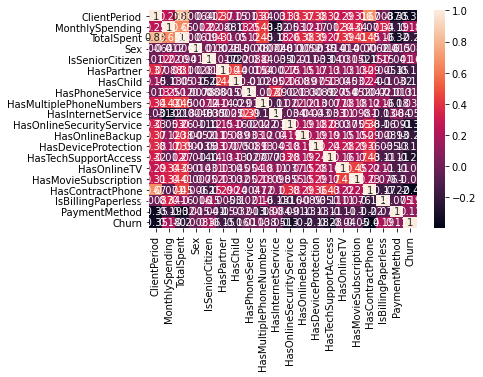

In [19]:
# корр матрица
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (20,10)

In [20]:
df.corr(method='pearson')

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
ClientPeriod,1.000000,0.249414,0.825103,0.006370,0.011561,0.370314,0.146120,0.013291,0.344992,-0.031391,0.334275,0.373151,0.375902,0.321828,0.285393,0.305789,0.672612,0.008711,-0.353928,-0.350640
MonthlySpending,0.249414,1.000000,0.651510,-0.011778,0.215456,0.087652,-0.125682,0.251283,0.427170,-0.319669,-0.052741,0.122113,0.167464,-0.012343,0.344368,0.342655,-0.070987,0.344868,-0.192028,0.184769
TotalSpent,0.825103,0.651510,1.000000,0.006146,0.093972,0.310383,0.049888,0.115825,0.451462,-0.176360,0.262486,0.376897,0.394234,0.274664,0.391899,0.406579,0.452534,0.156221,-0.323733,-0.201233
Sex,0.006370,-0.011778,0.006146,1.000000,0.013207,0.002780,0.014605,-0.007771,-0.000722,0.004759,-0.010827,-0.005213,0.000347,-0.014350,-0.013835,-0.007032,-0.006185,-0.015698,0.015102,-0.008325
IsSeniorCitizen,0.011561,0.215456,0.093972,0.013207,1.000000,0.016764,-0.217007,0.008763,0.138341,-0.035115,-0.123305,-0.010950,-0.032548,-0.143931,0.031011,0.052190,-0.145131,0.151964,-0.041062,0.156872
HasPartner,0.370314,0.087652,0.310383,0.002780,0.016764,1.000000,0.442530,0.001508,0.139554,0.000265,0.153188,0.146859,0.167990,0.130299,0.130824,0.131858,0.292764,-0.005293,-0.153509,-0.148347
HasChild,0.146120,-0.125682,0.049888,0.014605,-0.217007,0.442530,1.000000,-0.010475,-0.028929,0.052234,0.157814,0.088882,0.075208,0.133400,0.044780,0.032252,0.238125,-0.100777,-0.032327,-0.163609
HasPhoneService,0.013291,0.251283,0.115825,-0.007771,0.008763,0.001508,-0.010475,1.000000,-0.017241,0.393554,-0.020510,0.032771,0.008922,-0.026696,0.054057,0.052298,0.004736,0.021362,-0.012874,0.010849
HasMultiplePhoneNumbers,0.344992,0.427170,0.451462,-0.000722,0.138341,0.139554,-0.028929,-0.017241,1.000000,-0.106551,0.021904,0.119862,0.126918,0.007708,0.175284,0.178832,0.115848,0.159336,-0.177053,0.037866
HasInternetService,-0.031391,-0.319669,-0.176360,0.004759,-0.035115,0.000265,0.052234,0.393554,-0.106551,1.000000,-0.034393,0.039996,0.042815,-0.032575,0.113617,0.098057,0.100173,-0.129665,0.084306,-0.051106


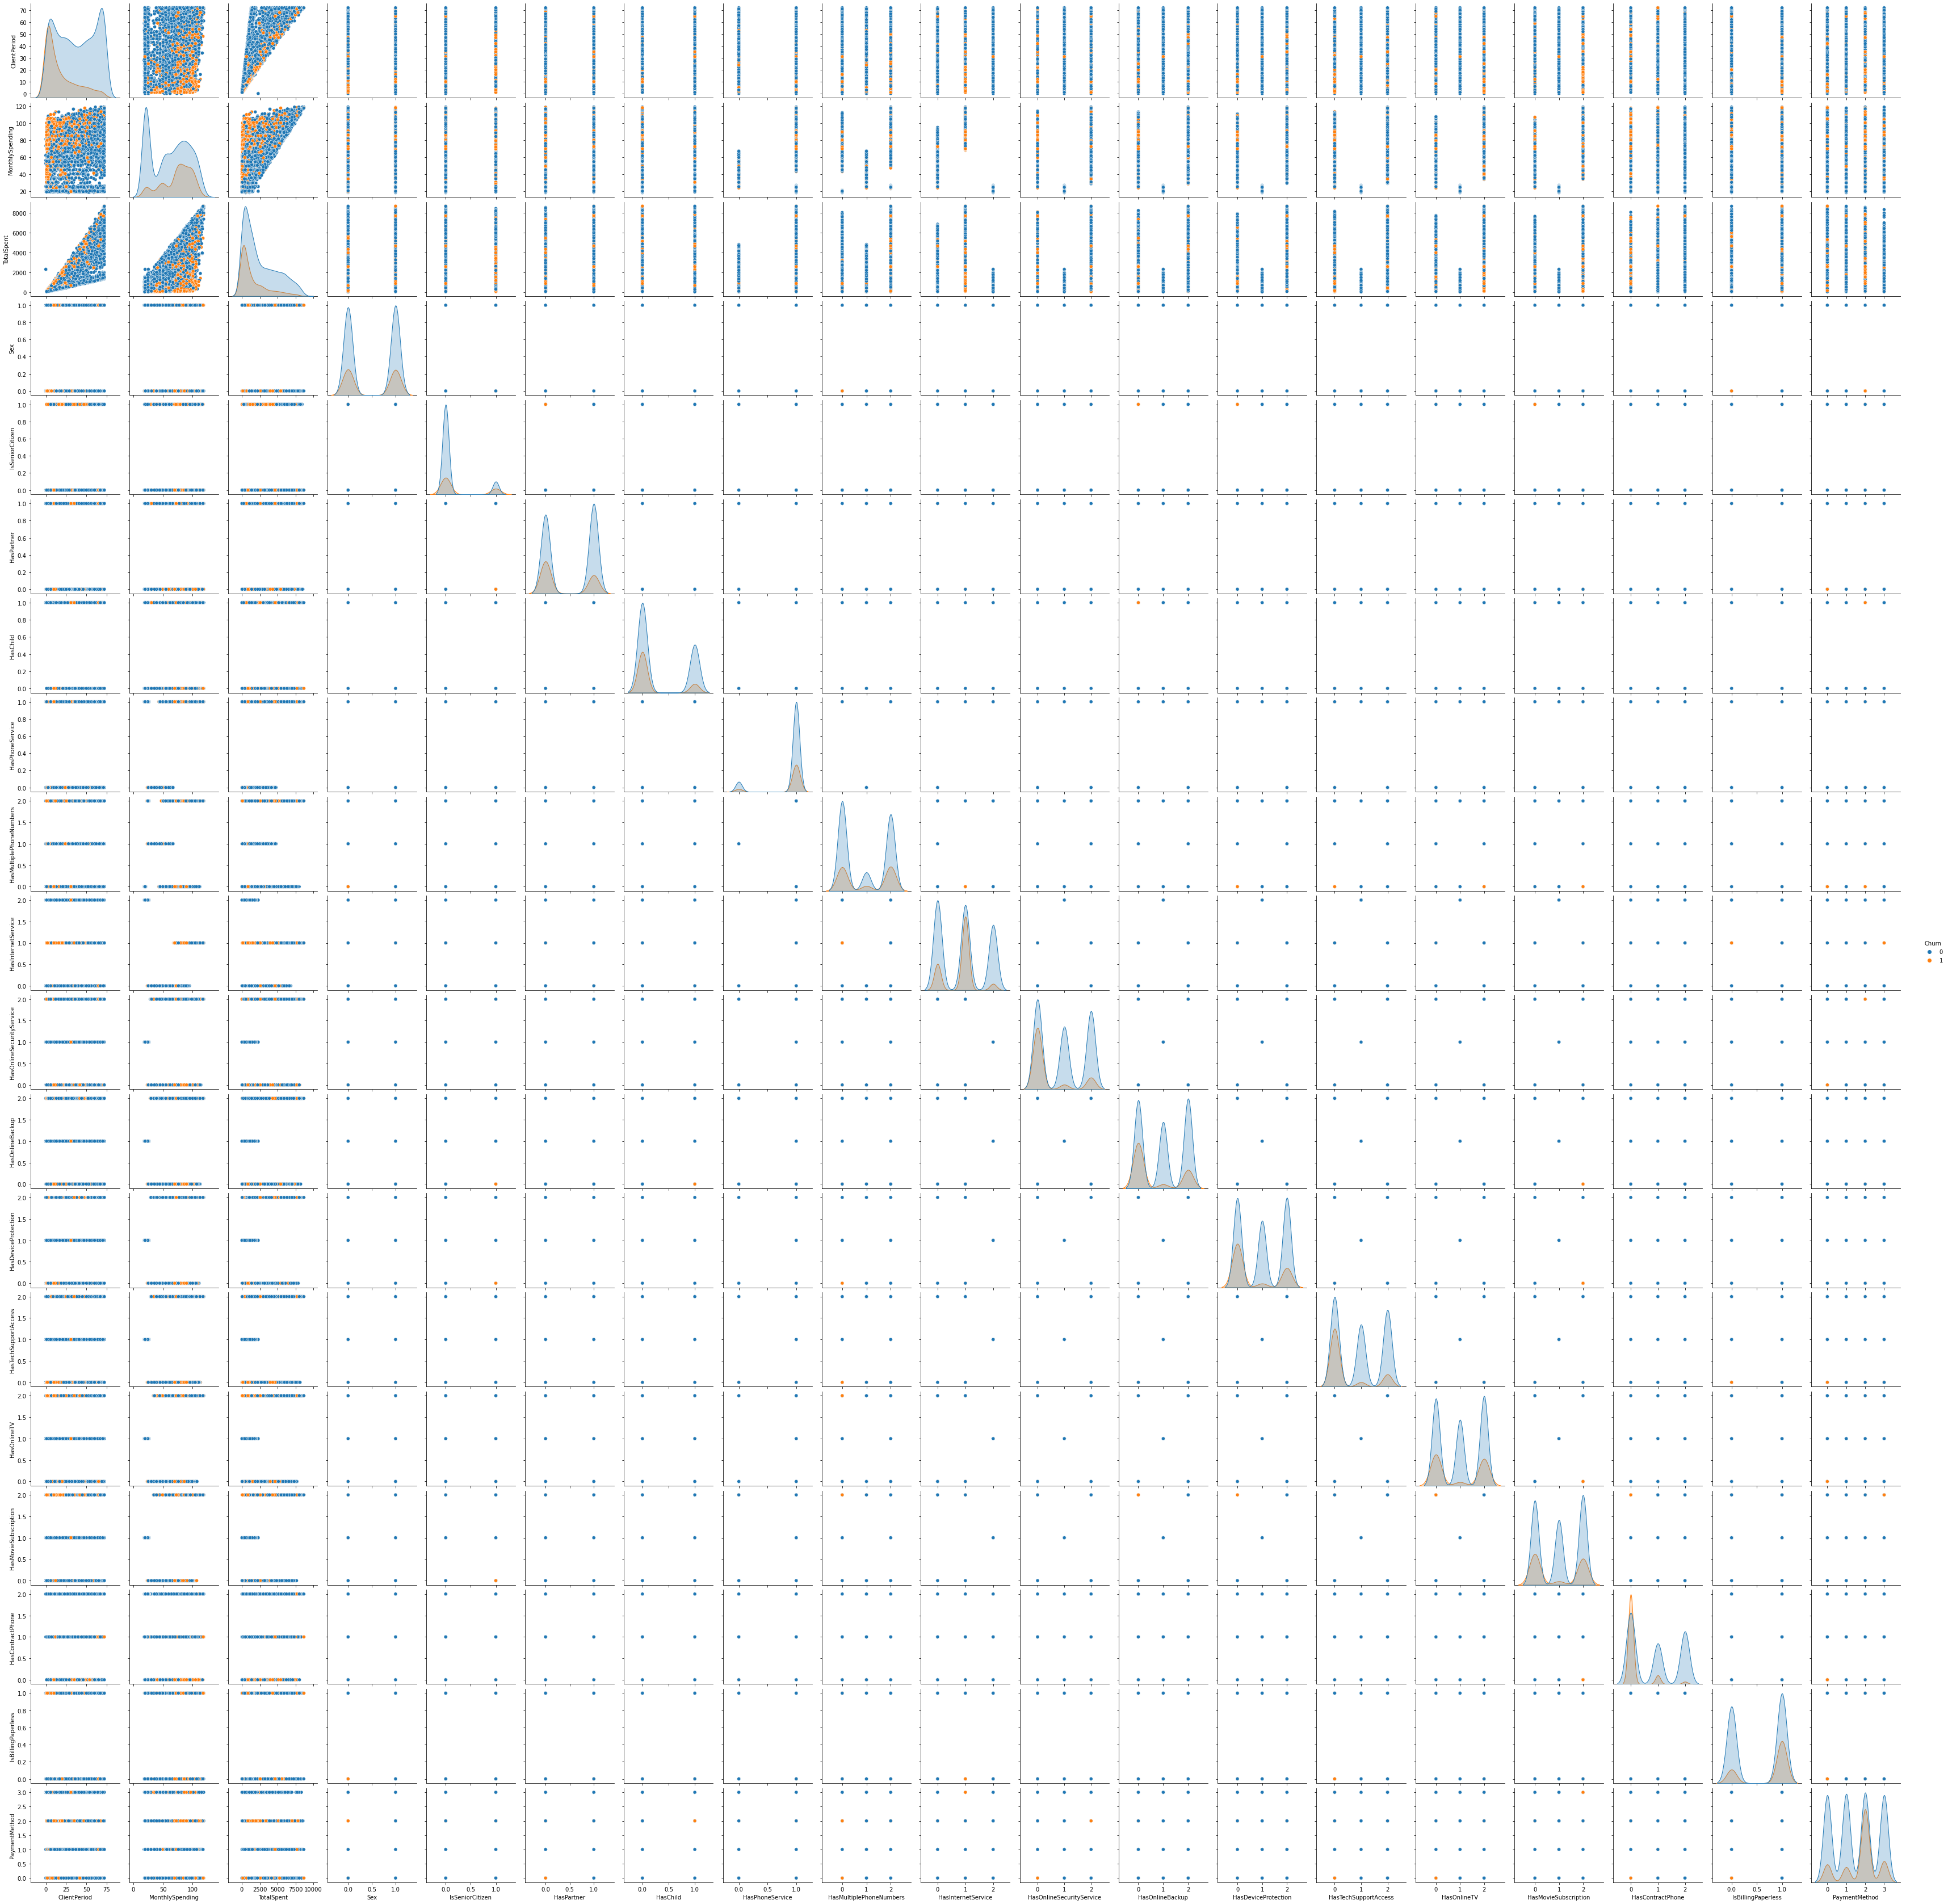

In [21]:
sns.pairplot(df, hue="Churn")

## Применение линейных моделей

In [22]:
# Scale and One-hot
scaler = StandardScaler()
scaler.fit(data[num_cols])
X_n = scaler.transform(data[num_cols])

enc = OneHotEncoder().fit(data[cat_cols])
X_c = enc.transform(data[cat_cols]).toarray()

print(X_n.shape, X_c.shape)

X = np.concatenate((X_n, X_c), axis= 1)
y = data['Churn']
X.shape

(5282, 3) (5282, 43)


(5282, 46)

In [23]:
enc544 = OneHotEncoder(sparse=False).fit(data[cat_cols])
X_c8658 = enc544.transform(data[cat_cols])
X_c8658

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.]])

In [24]:
# fit
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=43, shuffle=True)
clf = LogisticRegressionCV(cv=5, random_state=0, scoring='roc_auc', refit=True).fit(X_train, y_train)
print(clf.score(X_test, y_test)) # roc_auc_score(y_test, y_preds) # 0.8611778158947971
y_preds = clf.predict_proba(X_test)[:,1]

0.8611778158947971


In [25]:
# Permutation feature importance
import eli5
from eli5.sklearn import PermutationImportance

lr = LogisticRegression().fit(X_train, y_train)
perm = PermutationImportance(lr,random_state=1).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.0934 ± 0.0043,x0
0.0208 ± 0.0043,x2
0.0107 ± 0.0041,x37
0.0088 ± 0.0058,x17
0.0055 ± 0.0042,x1
0.0037 ± 0.0039,x39
0.0036 ± 0.0012,x40
0.0031 ± 0.0037,x41
0.0028 ± 0.0037,x16
0.0017 ± 0.0032,x19


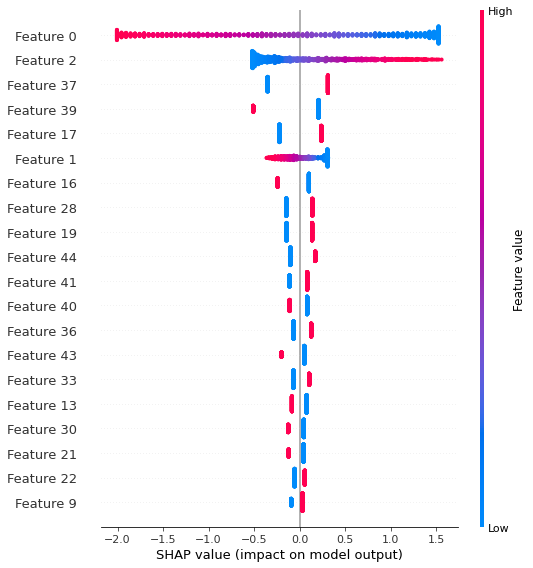

In [26]:
import shap  # package used to calculate Shap values

# use Kernel SHAP to explain test set predictions
masker = shap.maskers.Independent(data=X_test)
k_explainer = shap.LinearExplainer(lr, masker = masker)
k_shap_values = k_explainer.shap_values(X_test)
shap.summary_plot(k_shap_values, X_test)

In [27]:
# import lime
# import lime.lime_tabular

# explainer = lime.lime_tabular.LimeTabularExplainer(X_train)
# exp = explainer.explain_instance(df.iloc[0].astype(int).values, lr.predict)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [28]:
# one-hot and scale для test.csv
X_test_f0 = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')


# Удаление пустых
X_test_f1 = X_test_f0.replace(' ', np.nan)
X_test_f1 = X_test_f1.dropna()

X_test_f2 = pd.to_numeric(X_test_f1['TotalSpent'])
X_test_f1['TotalSpent'] = X_test_f2

# заменяем на среднее значение:

mean_ = X_test_f1['TotalSpent'].mean()
X_test_f0 = X_test_f0.replace(' ', mean_)

print(X_test_f0.shape)


X_n_f = scaler.transform(X_test_f0[num_cols])
X_c_f = enc.transform(X_test_f0[cat_cols]).toarray()

print(X_n_f.shape, X_c_f.shape)

X_test_f0 = np.concatenate((X_n_f, X_c_f), axis = 1)
X_test_f0.shape

(1761, 19)
(1761, 3) (1761, 43)


(1761, 46)

## Применение градиентного бустинга

In [29]:
y = data['Churn']
X = data.drop('Churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=43, shuffle=True)

Стандартные параметры

In [31]:
model = CatBoostClassifier()

# Fit model
model.fit(X_train, y_train, cat_features=cat_cols, verbose=0) #  eval_metric = 'AUC'

# Get predictions
y_preds = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_preds) # 0.8580760434534019

0.8581546598056031

Поиск по сетке

In [35]:
def search_cat_boost_params():
    params = {'depth':[6,4,7,10],
              'iterations':[250,100,500,1000],
              'learning_rate':[0.03,0.1,0.2,0.3],
              'l2_leaf_reg':[3,1,5,10]}
    model2 = CatBoostClassifier(cat_features=cat_cols, custom_metric='AUC:hints=skip_train~false')
    grid_search_result = model2.grid_search(params,
                                           X=X_train,
                                           y=y_train,
                                           cv=3,
                                           partition_random_seed=3,
                                           stratified=True,
                                       )
    return grid_search_result
  
# found_parameters = search_cat_boost_params() # Закомментировал, т.к. поиск очень долгий  
# print(found_parameters['params']) # grid_search_result['cv_results']

# Модель с найденными параметрами:

model4 = CatBoostClassifier(depth=4, l2_leaf_reg=1, iterations=100, learning_rate=0.1)

# Fit model
model4.fit(X_train, y_train, cat_features=cat_cols, verbose=0) #  eval_metric = 'AUC'
# Get predictions
y_preds = model4.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_preds) # 0.8643844101391271

0.8370449780827139

пробую улучшить

In [84]:
y = data['Churn']
X = data.drop('Churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X[num_cols], y, train_size=0.8, random_state=43, shuffle=True)

# NN
from sklearn.neural_network import MLPClassifier

clf123 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(196,32, 16), random_state=1)
clf123.fit(X_train, y_train)
y_preds = clf123.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_preds)

0.8279040404040403

In [98]:
# PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_1 = poly.fit_transform(X[num_cols])
X_1.shape
X_1 = pd.DataFrame(X_1)
X_poly = pd.concat([X[cat_cols], X_1], axis=1)
X_poly.head()

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,...,0,1,2,3,4,5,6,7,8,9
0,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,...,1.0,55.0,19.50,1026.35,3025.0,1072.5,56449.25,380.2500,20013.8250,1.053394e+06
1,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,...,1.0,72.0,25.85,1872.20,5184.0,1861.2,134798.40,668.2225,48396.3700,3.505133e+06
2,Male,0,No,No,Yes,No,Fiber optic,No,No,No,...,1.0,1.0,75.90,75.90,1.0,75.9,75.90,5760.8100,5760.8100,5.760810e+03
3,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,...,1.0,32.0,79.30,2570.00,1024.0,2537.6,82240.00,6288.4900,203801.0000,6.604900e+06
4,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,...,1.0,60.0,115.25,6758.45,3600.0,6915.0,405507.00,13282.5625,778911.3625,4.567665e+07


In [87]:
y = data['Churn']
X = data.drop('Churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X[cat_cols], y, train_size=0.8, random_state=43, shuffle=True)

In [38]:
model5 = CatBoostClassifier(depth=4, l2_leaf_reg=1, iterations=100, learning_rate=0.1)
model5.fit(X_train, y_train, cat_features=cat_cols, verbose=0) #  eval_metric = 'AUC'
y_preds = model4.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_preds) # 0.8370449780827139

0.8370449780827139

In [101]:
# CatBoost with PolynomialFeatures
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=0.8, random_state=43, shuffle=True)
model6 = CatBoostClassifier(depth=4, l2_leaf_reg=1, iterations=100, learning_rate=0.1)
model6.fit(X_train, y_train, cat_features=cat_cols, verbose=0) #  eval_metric = 'AUC'
y_preds = model6.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_preds) # 0.8637078330474556

0.8637078330474556

Попробуем поискать новые гипер-параметры

In [108]:
def search_cat_boost_params():
    params = {'depth':[6,4,7,10],
              'iterations':[250,100,500,1000],
              'learning_rate':[0.03,0.1,0.2,0.3],
              'l2_leaf_reg':[3,1,5,10]}
    model6 = CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC')
    grid_search_result = model6.grid_search(params,
                                           X=X_train,
                                           y=y_train,
                                           cv=3,
                                           partition_random_seed=3,
                                           stratified=True,
                                       )
    return grid_search_result
  
found_parameters = search_cat_boost_params() # Закомментировал, т.к. поиск очень долгий  
print(found_parameters['params']) # grid_search_result['cv_results']


bestTest = 0.8065345455
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8065345	best: 0.8065345 (0)	total: 2.77s	remaining: 11m 45s

bestTest = 0.8046472727
bestIteration = 22

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8046473	best: 0.8065345 (0)	total: 5.6s	remaining: 11m 51s

bestTest = 0.8067454545
bestIteration = 29

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8067455	best: 0.8067455 (2)	total: 8.65s	remaining: 12m 9s

bestTest = 0.8036036364
bestIteration = 17

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8036036	best: 0.8067455 (2)	total: 11.6s	remaining: 12m 11s

b


bestTest = 0.8046472727
bestIteration = 22

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
33:	loss: 0.8046473	best: 0.8077855 (8)	total: 1m 7s	remaining: 7m 19s

bestTest = 0.8067454545
bestIteration = 29

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
34:	loss: 0.8067455	best: 0.8077855 (8)	total: 1m 13s	remaining: 7m 44s

bestTest = 0.8036036364
bestIteration = 17

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
35:	loss: 0.8036036	best: 0.8077855 (8)	total: 1m 19s	remaining: 8m 7s

bestTest = 0.8054581818
bestIteration = 143

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
36:	loss: 0.8054582	best: 0.8077855 (8)	total: 1m 25s	remaining: 8m 2


bestTest = 0.8064218182
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
66:	loss: 0.8064218	best: 0.8081309 (40)	total: 5m 49s	remaining: 16m 26s

bestTest = 0.8047236364
bestIteration = 36

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
67:	loss: 0.8047236	best: 0.8081309 (40)	total: 5m 51s	remaining: 16m 11s

bestTest = 0.8059672727
bestIteration = 67

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
68:	loss: 0.8059673	best: 0.8081309 (40)	total: 5m 53s	remaining: 15m 57s

bestTest = 0.80732
bestIteration = 28

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
69:	loss: 0.8073200	best: 0.8081309 (40)	total: 5m 54s	remaining: 1


bestTest = 0.8047236364
bestIteration = 36

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
99:	loss: 0.8047236	best: 0.8081345 (74)	total: 6m 34s	remaining: 10m 15s

bestTest = 0.8059672727
bestIteration = 67

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
100:	loss: 0.8059673	best: 0.8081345 (74)	total: 6m 38s	remaining: 10m 11s

bestTest = 0.80732
bestIteration = 28

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
101:	loss: 0.8073200	best: 0.8081345 (74)	total: 6m 42s	remaining: 10m 7s

bestTest = 0.8021163636
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
102:	loss: 0.8021164	best: 0.8081345 (74)	total: 6m 45s	remaining: 


bestTest = 0.8077709091
bestIteration = 34

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
132:	loss: 0.8077709	best: 0.8081345 (74)	total: 9m 34s	remaining: 8m 51s

bestTest = 0.8042836364
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
133:	loss: 0.8042836	best: 0.8081345 (74)	total: 9m 37s	remaining: 8m 46s

bestTest = 0.8028254545
bestIteration = 3

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
134:	loss: 0.8028255	best: 0.8081345 (74)	total: 9m 41s	remaining: 8m 41s

bestTest = 0.79948
bestIteration = 14

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
135:	loss: 0.7994800	best: 0.8081345 (74)	total: 9m 45s	remaining: 8


bestTest = 0.8042836364
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
165:	loss: 0.8042836	best: 0.8081345 (74)	total: 11m 12s	remaining: 6m 4s

bestTest = 0.8028254545
bestIteration = 3

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
166:	loss: 0.8028255	best: 0.8081345 (74)	total: 11m 19s	remaining: 6m 2s

bestTest = 0.79948
bestIteration = 14

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
167:	loss: 0.7994800	best: 0.8081345 (74)	total: 11m 27s	remaining: 6m

bestTest = 0.80604
bestIteration = 102

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
168:	loss: 0.8060400	best: 0.8081345 (74)	total: 11m 34s	remaining: 5m 57s



bestTest = 0.8029672727
bestIteration = 9

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
198:	loss: 0.8029673	best: 0.8088655 (192)	total: 17m 37s	remaining: 5m 3s

bestTest = 0.7932727273
bestIteration = 5

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
199:	loss: 0.7932727	best: 0.8088655 (192)	total: 17m 47s	remaining: 4m 58s

bestTest = 0.80544
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
200:	loss: 0.8054400	best: 0.8088655 (192)	total: 17m 55s	remaining: 4m 54s

bestTest = 0.8081709091
bestIteration = 38

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
201:	loss: 0.8081709	best: 0.8088655 (192)	total: 18m 5s	remaini


bestTest = 0.7932727273
bestIteration = 5

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
231:	loss: 0.7932727	best: 0.8088655 (192)	total: 22m 8s	remaining: 2m 17s

bestTest = 0.80544
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
232:	loss: 0.8054400	best: 0.8088655 (192)	total: 22m 27s	remaining: 2m 12s

bestTest = 0.8081709091
bestIteration = 38

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
233:	loss: 0.8081709	best: 0.8088655 (192)	total: 22m 46s	remaining: 2m 8s

bestTest = 0.8078872727
bestIteration = 20

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
234:	loss: 0.8078873	best: 0.8088655 (192)	total: 23m 6s	remaini

In [109]:
# {'depth': 10, 'l2_leaf_reg': 3, 'iterations': 250, 'learning_rate': 0.03}

# CatBoost with PolynomialFeatures
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=0.8, random_state=43, shuffle=True)
model7 = CatBoostClassifier(depth=10, l2_leaf_reg=3, iterations=250, learning_rate=0.03)
model7.fit(X_train, y_train, cat_features=cat_cols, verbose=0) #  eval_metric = 'AUC'
y_preds = model7.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_preds) # 0.8578521059653135

0.8578521059653135

## Предсказания

In [ ]:
X_test_f = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

# CatBoostModel
prediction = model4.predict_proba(X_test_f)[:,1]
submission= pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')
submission['Churn'] = prediction
submission.to_csv('./advanced-dls-spring-2021 final.csv', index=False)

print(prediction)

In [ ]:
# LinearRegression model
prediction = clf.predict_proba(X_test_f0)[:,1]
submission= pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')
submission['Churn'] = prediction
submission.to_csv('./advanced-dls-spring-2021 final lr.csv', index=False)